# Лабораторная работа 2: решение СЛАУ

Рассматриваются алгортимы численного решения СЛАУ

$AX = b$

## Входные данные

Используем систему из II.10.5, пункт ***м)***.

![](assets/system.png)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

## Генерация входных данных

In [2]:
def generate_input(N = 20):
    A = np.zeros([N, N])
    B = np.empty([N])

    for i in range(N):
        A[i][i] = 10
        B[i] = i

    for i in range(0, N - 1):
        A[i][i + 1] = 1
        A[i + 1][i] = 1

    for i in range(0, N - 2):
        A[i][i + 2] = 0.1
        A[i + 2][i] = 0.1

    return A, B

A_task, B_task = generate_input()

## Вспомогательные функции

In [3]:
ZERO_TOLERANCE = 10**-4

def check_dims(matrices, vectors) -> int:
    dims = 0
    
    if len(matrices) != 0:
        dims = matrices[0].shape[0]
    elif len(vectors) != 0:
        dims = vectors[0].shape[0]
    else:
        raise RuntimeError("Empty input")
    
    for mat in matrices:
        if len(mat.shape) != 2:
            raise RuntimeError("Wrong tensor order")
        if mat.shape[0] != dims or mat.shape[1] != dims:
            raise RuntimeError("Wrong dimensions")
        
    for vec in vectors:
        if len(vec.shape) != 1:
            raise RuntimeError("Wrong tensor order")
        if vec.shape[0] != dims:
            raise RuntimeError("Wrong dimensions")
    
    return dims

def vec_equal(a, b):
    return np.linalg.norm(a - b) < ZERO_TOLERANCE

def validate(func, A = A_task, B = B_task):
    answer = func(A, B)
    
    if not vec_equal(answer, np.linalg.solve(A, B)):
        raise RuntimeError("Wrong answer")
    print("Ответ: \n", answer)
    print("Ответ сошелся!")

def get_any(s: set):
    elt = None
    for e in s:
        elt = e
        break
    return elt

def benchmark(f, A, B, powers):
    answer = np.linalg.solve(A, B)

    N = []
    for power in range(powers[0], powers[1] + 1):
        N.append(2**power)

    T = []

    for n in N:
        start = time.perf_counter()
        u = f(A, B, n)
        if not vec_equal(u, answer):
            raise RuntimeError("Wrong answer")

        T.append(time.perf_counter() - start)

    return N, T

def plot_benchmarks(fs, powers, title, labels):
    A, B = generate_input()

    for f, label in zip(fs, labels):
        N, T = benchmark(f, A, B, powers)
        plt.plot(N, T, label=label)

    plt.title(title)
    plt.grid()
    plt.xlabel("$Количество ~итераций$")
    plt.ylabel("$Время,~ c$")
    
    plt.xscale("log", base=2)
    #plt.yscale("log", base=2)
    plt.legend()

    plt.show()

def plot_remainders(fs, labels, N):
    A, B = generate_input(10)
    X = list(range(N))
    for f, label in zip(fs, labels):
        _, R = f(A, B, N)
        plt.plot(X, R, label=label)

    plt.grid()
    plt.title("График убывания невязки")
    plt.legend

    plt.xlabel("$Количество ~итераций ~s$")
    plt.ylabel("$Невязка, ~ ||r^{(s)}||$")
    plt.legend()

    plt.show()


## 1. Метод Гаусса с выбором главного элемента

In [4]:
def gauss(A: np.ndarray, b: np.ndarray, do_print=False):
    dims = check_dims((A,), (b,))
    
    A = np.concatenate((A, np.array([b]).T), axis=1)

    if do_print: print("Исходная матрица: \n", A, "\n")

    # Forward
    if do_print: print("Прямой ход: ")
    
    indices = set(range(dims))
    sequence = []
    i_max = None

    for n in range(dims-1):
        i_max = get_any(indices)
        for i in indices:
            if (abs(A[i][n]) > abs(A[i_max][n])):
                i_max = i

        if (abs(A[i_max][n]) < ZERO_TOLERANCE):
            raise RuntimeError("No solution: determinant is zero")

        indices.remove(i_max)
        sequence.append(i_max)

        for i in indices:
            A[i] -= A[i_max] * (A[i][n] / A[i_max][n])

        if do_print: print(A, "\n")
    
    assert len(indices) == 1
    sequence.append(indices.pop())

    # Backward
    if do_print: print("Обратный ход: ")

    indices = set(range(dims))
    for n in range(1, dims)[::-1]:
        i_last = sequence[n]
        indices.remove(i_last)

        for i in indices:
            A[i] -= A[i_last] * (A[i][n] / A[i_last][n])

        if do_print: print(A, "\n")

    answer = np.empty_like(b)

    for i in range(dims):
        answer[i] = (A[sequence[i]][dims] / A[sequence[i]][i])

    if do_print: print("Результат: \n", answer)

    return answer

In [5]:
validate(gauss)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


## 2. LUP-разложение

In [6]:
def lup_factorization(A: np.ndarray):
    dims = check_dims((A, ),())

    L = np.zeros_like(A)
    U = A.copy()
    P = np.zeros_like(A)
    
    indices = set(range(dims))

    for n in range(dims-1):
        i_max = get_any(indices)
        for i in indices:
            if (abs(U[i][n]) > abs(U[i_max][n])):
                i_max = i

        if (abs(U[i_max][n]) < ZERO_TOLERANCE):
            raise RuntimeError("No solution: determinant is zero")

        indices.remove(i_max)

        P[n][i_max] = 1

        for i in indices:
            L[i][n] = U[i][n] / U[i_max][n]
            U[i] -= U[i_max] * L[i][n]

        L[i_max][n] = 1

    assert len(indices) == 1
    ind = indices.pop()
    P[dims-1][ind] = 1
    L[ind][dims-1] = 1


    # Тут мы умножаем на матрицу перестановок, но этого в принципе
    # можно добиться и прямой перестановкой строк
    return np.dot(P, L), np.dot(P, U), P

def lup_solve(A: np.ndarray, B: np.ndarray):
    dims = check_dims((A,), (B,))

    L, U, P = lup_factorization(A)

    PB = np.dot(P, B)

    v = np.empty_like(B)
    u = np.empty_like(B)

    for i in range(dims):
        v[i] = PB[i]
        for j in range(i):
            v[i] -= v[j]*L[i][j]
        v[i] /= L[i][i]

    for i in range(dims)[::-1]:
        u[i] = v[i]
        for j in range(i + 1, dims):
            u[i] -= u[j] * U[i][j]
        u[i] /= U[i][i]


    return u


In [7]:
validate(lup_solve)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


## 3. Метод Якоби

Данный метод можно c одинаковой асимптотикой реализовать и с использованием матричных операций, и с использованием покомпонентной записи. Я склоняюсь к матричным операциям, потому что они должны быть значительно производительнее. Реализуем двумя способами и сравним производительность.

In [8]:
def jacob_mat(A, f, N, u0 = None):
    if u0 is None: u0 = np.zeros_like(f)

    check_dims((A,), (f, u0))
    diag = np.diag(A)

    u = u0

    # N*O(n^2)
    for _ in range(N):
        u += (f - np.dot(A, u)) / diag 
    
    return u

def jacob_elt(A, f, N, u0 = None):
    if u0 is None: u0 = np.zeros_like(f)
    dims = check_dims((A,), (f, u0))

    u = u0

    # N*O(n^2)
    for _ in range(N):
        u_prev = u
        for i in range(dims):
            s = 0
            for j in range(dims):
                if (j == i): continue
                s += A[i][j]*u_prev[j]

            u[i] = (f[i] - s) / A[i][i]

    return u

In [9]:
jacob_mat_def = lambda A, f: jacob_mat(A, f, 100)
jacob_elt_def = lambda A, f: jacob_elt(A, f, 100)

validate(jacob_elt_def)
validate(jacob_mat_def)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!
Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


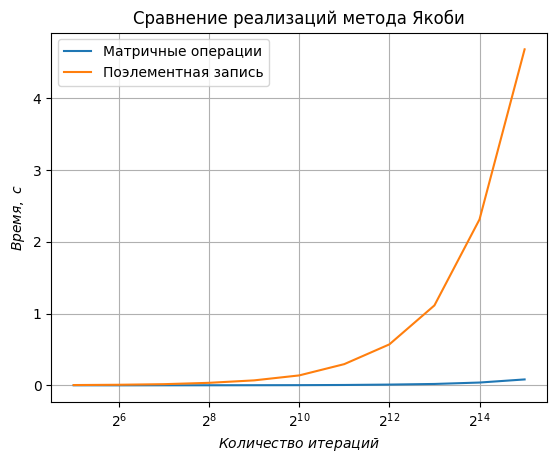

In [10]:
fs = (jacob_mat, jacob_elt)
labels = ("Матричные операции", "Поэлементная запись")
title = "Сравнение реализаций метода Якоби"

plot_benchmarks(fs, [5, 15], title, labels)


Ожидаемо, матричные операции значительно быстрее покомпонентной записи.

Отдельно реализуем метод Якоби, сохраняющий значения невязки в процессе итераций.

In [11]:
def jacob_r(A, f, N, u0 = None):
    if u0 is None: u0 = np.zeros_like(f)

    check_dims((A,), (f, u0))
    diag = np.diag(A)

    u = u0
    R = []
    for _ in range(N):
        u += (f - np.dot(A, u)) / diag
        R.append(np.linalg.norm(f - np.dot(A, u)))

    return u, R

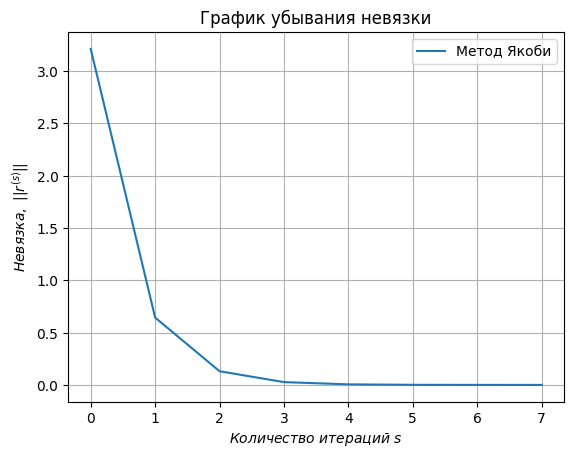

In [12]:
plot_remainders((jacob_r,), ("Метод Якоби",), 8)

## 4. Метод Зейделя

В данном методе тоже можно использовать матричные операции, однако в таком случае мы потеряем в асимптотике: придется считать матрицу $(D + L)^{-1}$, что уже $O(n^3)$. Поэтому будем делать поэлементную запись.

In [13]:
def seidel(A, f, N, u0=None):
    if u0 is None: u0 = np.zeros_like(f)
    dims = check_dims((A,), (f, u0))

    R = []
    u = u0
    for _ in range(N):
        for i in range(dims):
            u[i] = f[i]
            for j in range(i):
                u[i] -= A[i][j]*u[j]
            for j in range(i+1, dims):
                u[i] -= A[i][j]*u[j]

            u[i] /= A[i][i]

        r = np.dot(A, u) - f
        R.append(np.linalg.norm(r))
    return u, R


seidel_def = lambda A, f: seidel(A, f, 20)[0]
validate(seidel_def)


Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


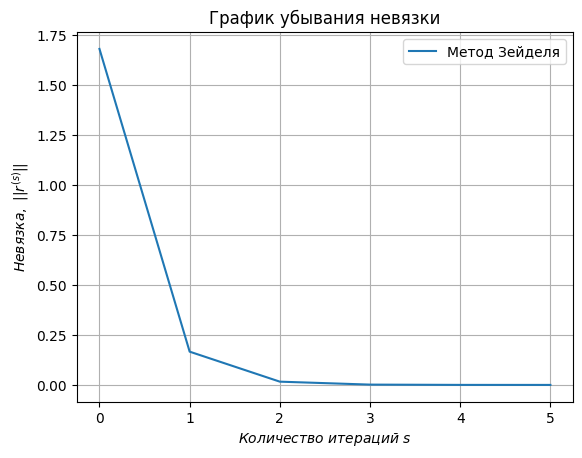

In [14]:
plot_remainders((seidel,), ("Метод Зейделя",), 6)

Как мы видим, метод Зейделя сходится быстрее метода Якоби для данной матрицы

## 5. Метод верхней релаксации

In [15]:
W_DEFAULT = 1

def SOR(A, f, N, u0=None, w=None):
    if u0 is None: u0 = np.zeros_like(f)
    if w is None: w = W_DEFAULT
    dims = check_dims((A,), (f, u0))

    R = []
    u = u0
    for _ in range(N):
        for i in range(dims):
            u_prev_i = u[i]
            u[i] = f[i]
            for j in range(i):
                u[i] -= A[i][j]*u[j]
            for j in range(i+1, dims):
                u[i] -= A[i][j]*u[j]

            u[i] *= w / A[i][i]
            u[i] += (1 - w) * u_prev_i

        r = np.dot(A, u) - f
        R.append(np.linalg.norm(r))
    return u, R

In [16]:
SOR_def = lambda A, f: SOR(A, f, 100)[0]
validate(SOR_def)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


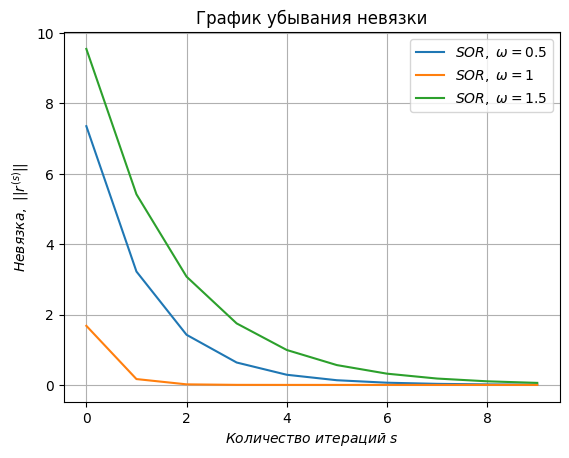

In [17]:
SOR_1 = lambda A, f, N: SOR(A, f, N, None, 0.5)
SOR_2 = lambda A, f, N: SOR(A, f, N, None, 1)
SOR_3 = lambda A, f, N: SOR(A, f, N, None, 1.5)

fs = (SOR_1, SOR_2, SOR_3)
labels = ("$SOR, ~\omega = 0.5$",
          "$SOR, ~\omega = 1$",
          "$SOR, ~\omega = 1.5$")

plot_remainders(fs, labels, 10)

## 6. Градиентный спуск

In [18]:
T_DEFAULT = 0.1

def grad_descent(A, f, N, u0=None, t=None):
    if t is None: t = T_DEFAULT
    if u0 is None: u0 = np.zeros_like(f)

    check_dims((A,), (f, u0))

    u = u0
    R = []
    for _ in range(N):
        u -= t * (np.dot(A, u) - f)

        # Вычисление невязок для графика
        r = np.dot(A, u) - f
        R.append(np.linalg.norm(r))

    return u, R

grad_def = lambda A, f: grad_descent(A, f, 100)[0]
validate(grad_def)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


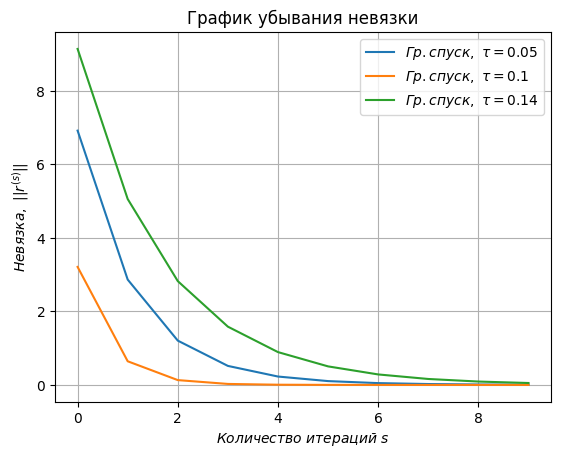

In [19]:
grad_1 = lambda A, f, N: grad_descent(A, f, N, None, 0.05)
grad_2 = lambda A, f, N: grad_descent(A, f, N, None, 0.1)
grad_3 = lambda A, f, N: grad_descent(A, f, N, None, 0.13)

functions = (grad_1, grad_2, grad_3)

labels = ("$Гр. спуск, ~\\tau = 0.05$",
          "$Гр. спуск, ~\\tau = 0.1$",
          "$Гр. спуск, ~\\tau = 0.14$")

plot_remainders(functions, labels, 10)

## 7. Метод минимальных невязок

In [20]:
def least_rem(A, f, N, u0=None):
    if u0 is None: u0 = np.zeros_like(f)

    check_dims((A,), (f, u0))

    u = u0
    R = []
    for _ in range(N):
        r = np.dot(A, u) - f
        Ar = np.dot(A, r)

        t = np.dot(Ar.T, r) / np.dot(Ar.T, Ar)

        u -= t * r

        # Вычисление невязок для графика
        r = np.dot(A, u) - f
        R.append(np.linalg.norm(r))

    return u, R

least_rem_def = lambda A, f: least_rem(A, f, 100)[0]
validate(least_rem_def)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


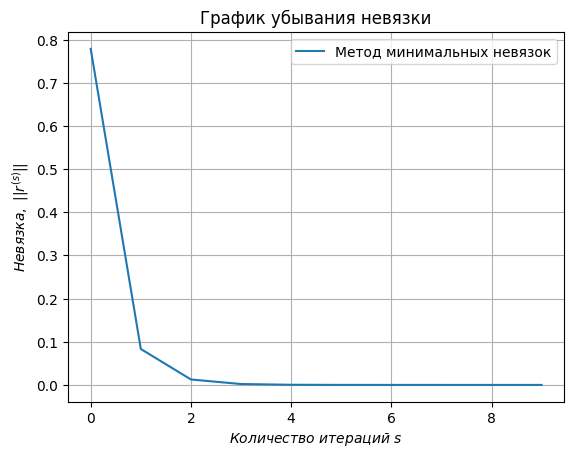

In [21]:
plot_remainders((least_rem,), ("Метод минимальных невязок",), 10)

## 8. Метод сопряженных градиентов

In [22]:
def conjgrad(A, f, N, u0=None):
    if u0 is None: u0 = np.zeros_like(f)
    check_dims((A,), (f, u0))

    u = u0
    p = np.dot(A, u) - f
    r2_prev = np.dot(p.T, p)

    R = []
    for _ in range(N):
        r = np.dot(A, u) - f
        
        r2 = np.dot(r.T, r) 
        b = r2 / r2_prev
        r2_prev = r2

        p = r + b*p

        t = np.dot(r.T, p) / np.linalg.multi_dot((p.T, A, p))

        u = u - t * p

        # Вычисление невязок для графика
        r = np.dot(A, u) - f
        R.append(np.linalg.norm(r))

    return u, R

conjgrad_def = lambda A, f: conjgrad(A, f, 100)[0]
validate(conjgrad_def)

Ответ: 
 [-0.00985263  0.08212453  0.16401822  0.24589167  0.327869    0.40983615
  0.49180327  0.57377049  0.65573771  0.73770492  0.81967213  0.90163934
  0.98360656  1.06557396  1.14753927  1.22950678  1.31165872  1.3917684
  1.47383671  1.73869865]
Ответ сошелся!


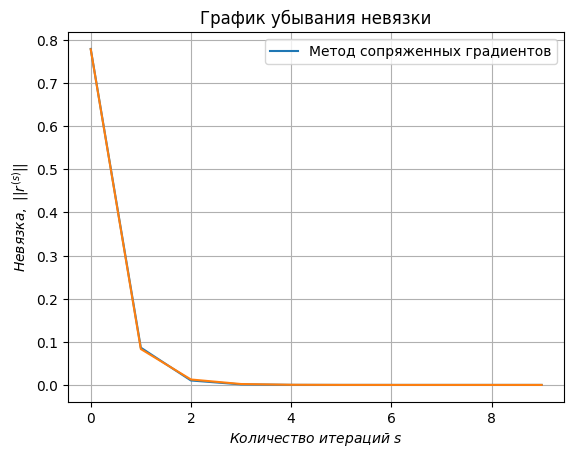

In [23]:
plot_remainders((conjgrad, least_rem), ("Метод сопряженных градиентов", ""), 10)

## Бонус: сравнение итерационных и вариационных методов

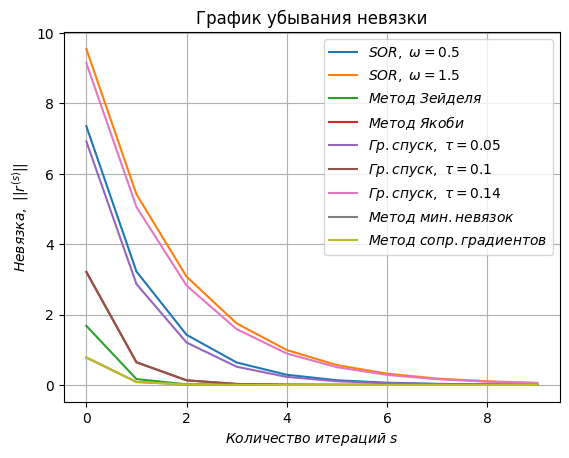

In [24]:
SOR_1 = lambda A, f, N: SOR(A, f, N, None, 0.5)
SOR_3 = lambda A, f, N: SOR(A, f, N, None, 1.5)

grad_1 = lambda A, f, N: grad_descent(A, f, N, None, 0.05)
grad_2 = lambda A, f, N: grad_descent(A, f, N, None, 0.1)
grad_3 = lambda A, f, N: grad_descent(A, f, N, None, 0.13)

fs = (SOR_1, SOR_3, seidel, jacob_r, grad_1, grad_2, grad_3, least_rem, conjgrad)
labels = ("$SOR, ~\omega = 0.5$",
          "$SOR, ~\omega = 1.5$",
          "$Метод ~Зейделя$",
          "$Метод ~Якоби$",
          "$Гр. спуск, ~\\tau = 0.05$",
          "$Гр. спуск, ~\\tau = 0.1$",
          "$Гр. спуск, ~\\tau = 0.14$",
          "$Метод ~мин. невязок$",
          "$Метод ~сопр. градиентов$"
          )

plot_remainders(fs, labels, 10)